,MW,Initial Thickness
0,50000,1
1,100000,1
2,200000,1


AttributeError: 'AxesSubplot' object has no property 'xmax'

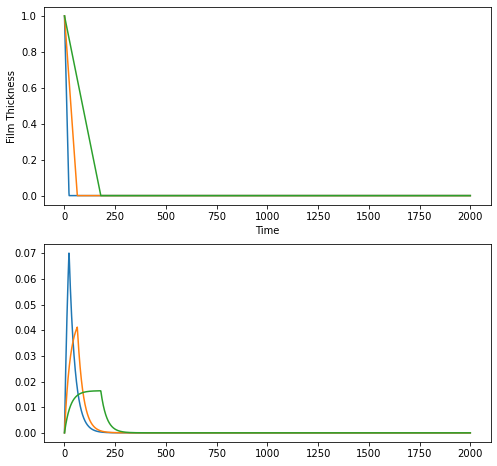

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

th_all = []
conc_all = [0]
t_half = 20
conc = 0.1

k=5E5
r_met = 0.0003

MW = 100000
th_init = 1
Rd = k*MW**(-3/2)

t = range(0,2001)


def limit(num,minimum=0):   #,maximum=100):
    if num <= minimum:
        return minimum
#     elif num >= maximum:
#         return maximum
    else:
        return num

def ConcProfile():
    Current_conc = 0
    global conc_all 
    conc_all = [0]
    global Rd
    global th_all
    th_all = []  
    global th_init
    global conc
    
    for i in range(len(t)):
        if i == 0:
            th_now = th_init
            th_prev = th_now
            th_all.append(th_now)

        else:
            th_now = limit(th_init - Rd*t[i]) #remove th by rate, determined by MW

            th_all.append(th_now) #make a list of th at each t



    #         loss_rate = (Current_conc)*2**(-(i)/t_half)*math.log(2)/t_half # using (1) as the dt here
            loss_to_conc = Current_conc*(1/2)**((1)/t_half) # using (1) as the dt here

            Current_conc = loss_to_conc
            Current_conc = Current_conc + (th_prev-th_now)*conc #add conc from dissolved polymer
            conc_all.append(Current_conc)
            th_prev = th_now

    return conc_all
    return th_all

#list of samples with MW and initial thickness
samples = [
    [50000,1],
    [100000,1],
    [200000,1]
]

df = pd.DataFrame(samples,columns=['MW','Initial Thickness'])
display(df)



figure, axis = plt.subplots(2, figsize=(8,8))

for index,row in df.iterrows():
    MW = df['MW'].iloc[index]
    th_init = df['Initial Thickness'].iloc[index]
    label = f'MW:{MW}, th={th_init}'
    
    Rd = k*MW**(-3/2)
    th = th_init-Rd*t
    th_lim = [limit(i) for i in th]
    
    ConcProfile()
    axis[1].plot(t,conc_all,label=label)
    axis[0].plot(t,th_all,label=label)
    
#     th_all = []
#     conc_all = [0]

    
axis[0].set(xlabel='Time', ylabel='Film Thickness', xmax=200)
axis[1].set(xlabel='Time', ylabel='Active Dose')
axis[0].label_outer()
axis[1].axhline(y=0.013, linestyle='dashed', color='gray')
axis[1].axhline(y=0.06, linestyle='dashed', color='r')
# axis[0].xlabel('Time')
# axis[0].ylabel('Active Dose')
# axis[0].ylim(0)
# axis[0].xlim(0)
axis[0].legend()
plt.show()




In [2]:
print(len(t))
print(len(conc_all))

2001
2001


In [ ]:
from dash import Dash, html, Input, Output, dcc
import dash_daq as daq
import plotly.express as px 
import numpy as np
import plotly.graph_objects as go

t_length = 1001
UCL = [0.06]*t_length
LED = [0.013]*t_length


value = 0
th_value = 1
conc_all = [0]*t_length
t = np.arange(0,t_length)


conc_all = [0]
th_all = []
conc_all = [0]
t_half = 20
conc = 0.1
MW = 100000
th_init = 1
Rd = k*MW**(-3/2)
time_to_active = 1
time_spent_active = 1



# ___MAIN___
app = Dash(__name__)

app.layout = html.Div([
    html.Div(children=[
    
    html.Label('Membrane Design:', style={'color': 'lightblue', 'fontSize': 28}),
    html.Label(' '),
    daq.Knob(id='my-knob-1',
            value=100000,
            min=0,
            max=500000,
            label='Molecular weight (g/mol)',
            scale={'interval': 100000, 'labelInterval':1},
            ),
        
    html.Br(),
    daq.Knob(id='my-knob-2',
            value=1,
            min=0,
            max=3,
            label='Thickness (a.u.)',
            scale={'interval': 0.5, 'labelInterval':1}
            ), 
    
  
    daq.Knob(id='my-knob-3',
            value=1,
            min=0,
            max=3,
            label='Drug Concentration (g/cc)',
            scale={'interval': 0.5, 'labelInterval':1}
            )]),
    

    html.Div(children=[
        html.Br(),
        html.Div(id='plot1'),
        html.Br(),
        html.Br(),
        html.Div(id='message1', style={'color': 'black', 'fontSize': 28, 'textAlign': 'center'}),
        html.Br(),
        html.Div(id='message2', style={'color': 'black', 'fontSize': 28, 'textAlign': 'center'})
    ])


], style={'display': 'flex', 'flex-direction':'row', "align-items":"flex-start"})




    
@app.callback([
Output('plot1', 'children'),
Output('message1', 'children'),
Output('message2', 'children')],
Input('my-knob-1', 'value'),
Input('my-knob-2','value'),
Input('my-knob-3', 'value'),
prevent_initial_call='initial_duplicate')

def render_plot(value, th_value, conc_value):  
        global MW
        MW = value
        global th_init
        th_init = th_value
        global conc_all
        global th_all
        global Rd
        global conc
        conc = conc_value
        
        Rd = k*MW**(-3/2) 
        th = th_init-Rd*t
        th_lim = [limit(i) for i in th]

        ConcProfile() #generate conc profile from inputs out as th_all and conc_all
        
        Above_LED = np.subtract(np.array(conc_all), np.array(LED))
        firstIndex = next((index for index, value in enumerate(Above_LED) if value > 0), -1) #find index of first time conc becomes effective
        lastIndex = t_length - next((index for index, value in enumerate(reversed(Above_LED)) if value > 0), -1) #find index when conc stops being effective
        
        time_to_active = firstIndex
        time_spent_active = round((lastIndex - firstIndex)/24,2)

        msg1 = f'Onset of action: {time_to_active} hours'
        msg2 = f'Duration of drug action: {time_spent_active} days'

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=t, y=conc_all, line = dict(color='black', width=5)))
        fig.update_xaxes(range=[0, 480])
        fig.update_layout(
            autosize=False,
            width=900,height=600,
            xaxis_title="Time (hr)",
            yaxis_title="Active Drug Concentration",
            template='simple_white',
            font=dict(size=22))
        
        fig.add_trace(go.Scatter(x=t, y=UCL, line = dict(color='red', width=3, dash='dash')))
        fig.add_trace(go.Scatter(x=t, y=LED, line = dict(color='green', width=3, dash='dash')))
    
        return html.Div(dcc.Graph(figure=fig), id='plot1'), msg1, msg2



if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
def simulate_film(MW,th_init,conc):
    k= 5E5
    t_half = 20
    UCL = 0.06
    LED = 0.013
    Rd = k*MW**(-3/2) 
    Current_conc = 0
    
    th_all = []
    conc_all = [0]
    
    
    t_length = 1001
    t = np.arange(0,t_length)
    UCL = 0.06
    LED = [0.013]*t_length

    
    for i in range(len(t)):
        if i == 0:
            th_now = th_init
            th_prev = th_now
            th_all.append(th_now)

        else:
            th_now = limit(th_init - Rd*t[i]) #remove th by rate, determined by MW

            th_all.append(th_now) #make a list of th at each t

            loss_to_conc = Current_conc*(1/2)**((1)/t_half) # using (1) as the dt here

            Current_conc = loss_to_conc
            Current_conc = Current_conc + (th_prev-th_now)*conc #add conc from dissolved polymer
            conc_all.append(Current_conc)
            th_prev = th_now
        
    Above_LED = np.subtract(np.array(conc_all), np.array(LED))
    firstIndex = next((index for index, value in enumerate(Above_LED) if value > 0), -1) #find index of first time conc becomes effective
    lastIndex = t_length - next((index for index, value in enumerate(reversed(Above_LED)) if value > 0), -1) #find index when conc stops being effective

    time_to_active = firstIndex #Could add interpolation here to get real time to active, currently estimate by the hour
    time_spent_active = round((lastIndex - firstIndex)/24,2) #time in days

    if np.max(conc_all) > UCL:
        is_safe = False
    else:
        is_safe = True


    return is_safe, time_to_active, time_spent_active




In [10]:
is_safe, time_to_active, time_spent_active = simulate_film(400000,0.45,1.4)

print(f'Safe?:{is_safe}, {time_to_active}hr to activate, {time_spent_active} days active')

Safe?:False, 6hr to activate, 11.46days active


In [20]:
#generate a sample database
#set n number of samples
#iterate n times, generate MW,th,conc randomly between values
#simulate the sample, then store 

num_samples = 3
features = [] #MW, th, conc
targets = [] #is_safe, time_to_active, time_spent_active

for i in range(num_samples):
    #generate a random sample
    temp_MW = np.random.randint(10000,500000)
    temp_th = np.random.randint(1,300)/100
    temp_conc = np.random.randint(5,300)/100
    
    temp_input = [temp_MW, temp_th, temp_conc]
    features.append(temp_input)
    
    #simulate the sample
    temp_is_safe, temp_time_to_active, temp_time_spent_active = simulate_film(temp_MW, temp_th, temp_conc)
    temp_result = [temp_is_safe, temp_time_to_active, temp_time_spent_active]
    targets.append(temp_result)

print("Features")
print(features)
print(" ")
print("Targets")
print(targets)

#this is working to simulate n samples and save features and targets in two lists
    

Features
[[326922, 1.04, 2.66], [486526, 0.27, 2.24], [361651, 0.86, 1.98]]
 
Targets
[[False, 2, 19.46], [False, 5, 9.88], [False, 3, 18.29]]


In [ ]:
#NN backwards to take the membrane performance and predict a construction



In [ ]:
Above_LED = np.subtract(np.array(conc_all), np.array(LED))

firstIndex = next((index for index, value in enumerate(Above_LED) if value > 0), -1)
lastIndex = next((index for index, value in enumerate(reversed(Above_LED)) if value > 0), -1)

print(firstIndex)
print(lastIndex)

# time_to_active = 1
# time_spent_active = 1

In [ ]:
#################
##TUTORIAL CODE##
#################
from dash import Dash, html, dcc

app = Dash(__name__)

app.layout = html.Div([
    html.Div(children=[
        html.Label('Dropdown'),
        dcc.Dropdown(['New York City', 'Montréal', 'San Francisco'], 'Montréal'),

        html.Br(),
        html.Label('Multi-Select Dropdown'),
        dcc.Dropdown(['New York City', 'Montréal', 'San Francisco'],
                     ['Montréal', 'San Francisco'],
                     multi=True),

        html.Br(),
        html.Label('Radio Items'),
        dcc.RadioItems(['New York City', 'Montréal', 'San Francisco'], 'Montréal'),
    ], style={'padding': 10, 'flex': 5}),

    html.Div(children=[
        html.Label('Checkboxes'),
        dcc.Checklist(['New York City', 'Montréal', 'San Francisco'],
                      ['Montréal', 'San Francisco']
        ),

        html.Br(),
        html.Label('Text Input'),
        dcc.Input(value='MTL', type='text'),

        html.Br(),
        html.Label('Slider'),
        dcc.Slider(
            min=0,
            max=9,
            marks={i: f'Label {i}' if i == 1 else str(i) for i in range(1, 6)},
            value=5,
        ),
    ], style={'padding': 10, 'flex': 1})
], style={'display': 'flex', 'flex-direction': 'row'})

if __name__ == '__main__':
    app.run_server(debug=True)
    
#optional for knob: style={'padding':2, 'flex':1}),
# font=dict(      family="Courier New, monospace",
#                 size=22
#                 color="RebeccaPurple")

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=conc_all),)
fig.add_trace(go.Scatter(x=t, y=t*2,))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    template='none',
    title = 'Plot Simple',
    title_font_size = 28,
    title_pad_t=1
)

fig.show()

In [ ]:
#active drug concentration, assume first order elimination kinetics
# N_t = N_0*(1/2)**(t/t_half)
# t_half = 0.693/k_rate
# N_t = No*exp(-k_rate*t)

k_rate = 0.1
t_half = 10

#loss rate
# R_loss = Co*(-k_rate)*math.exp(-k_rate*t)
for index,row in df.iterrows():
    MW = df['MW'].iloc[index]
    th_init = df['th_init'].iloc[index]
    label = f'MW:{MW}, th={th_init}'
    
    Rd = k*MW**(-3/2)
    th = th_init-Rd*t
    th_lim = [limit(i) for i in th]
    
    
    C_added = [-1*(th_lim[i]-th_lim[i-1])*conc for i in range(len(th_lim))]
    C_added[0] = 0

    Co = [sum(C_added[:i+1]) for i in range(len(C_added))]

    R_loss = (th*conc)*2**(-(t)/t_half)*math.log(2)/t_half #using (1) as the dt step, time elapsed between new points
#     C_total = Co - R_loss

    plt.plot(t,R_loss,label=label)
    
plt.xlabel('Time')
plt.ylabel('loss rate')
plt.legend()
plt.show()




In [ ]:
th_all = []
conc_all = [0]
t_half = 5
Current_conc = 0
conc = 0.1

MW = 100000
th_init = 1
Rd = k*MW**(-3/2)

def ConcProfile():
    for i in range(len(t)):
        if i == 0:
            th_now = th_init
            th_prev = th_now
            th_all.append(th_now)

        else:
            th_now = limit(th_init - Rd*t[i]) #remove th by rate, determined by MW

            th_all.append(th_now) #make a list of th at each t



    #         loss_rate = (Current_conc)*2**(-(i)/t_half)*math.log(2)/t_half # using (1) as the dt here
            loss_to_conc = Current_conc*(1/2)**((1)/t_half)

            Current_conc = loss_to_conc
            Current_conc = Current_conc + (th_prev-th_now)*conc #add conc from dissolved polymer
            conc_all.append(Current_conc)
            th_prev = th_now
        
        

        



plt.plot(t,conc_all)
plt.xlabel('Time')
plt.ylabel('th_all')
plt.show()

    

In [ ]:
list1 = [1,2,3,4,5,6,7]
list2 = [list1[i]-list1[i-1] for i in range(len(list1)-1)]
list2[0] = 0

print(list2)

In [ ]:
def limit(num,minimum=20,maximum=100):
    if num <= minimum:
        return minimum
    elif num >= maximum:
        return maximum
    else:
        return num


x = np.linspace(0,100)
y = 2*x

y_lim = [limit(i) for i in y]

plt.scatter(x,y_lim)
    
plt.xlim(0,100)
plt.ylim(0,1.5*max(y_lim))
plt.show()

In [ ]:
#example code from tutorial

angles = np.arange(-2*np.pi,2*np.pi,0.1)
p_cos = np.cos(angles)

fig, ax = plt.subplots()
ax.plot(angles,p_cos)

# add lines for between 1 and 6 terms in the Taylor Series
for i in range(1,6):
    t_cos = [func_cos(angle,i) for angle in angles]
    ax.plot(angles,t_cos)

ax.set_ylim([-7,4])

# set up legend
legend_lst = ['cos() function']
for i in range(1,6):
    legend_lst.append(f'Taylor Series - {i} terms')
ax.legend(legend_lst, loc=3)

plt.show()